In [3]:
%load_ext autoreload
%autoreload 2

In [17]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DateFormatter
import matplotlib.dates as mdates
import tensorflow as tf

from src.globals import processed_data_dir, saved_model_dir, vis_dir
from src.helpers import WindowGenerator, get_filenames_in_directory
from src.visualization import plot_metrics

In [5]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [6]:
# check GPU visibility
tf.config.get_visible_devices(
    device_type='GPU'
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
train_dir = processed_data_dir / 'train'
val_dir = processed_data_dir / 'val'
test_dir = processed_data_dir / 'test'

In [8]:
train_files = get_filenames_in_directory(train_dir)

In [9]:
# number of features
# 11
cols = pd.read_csv(train_dir/train_files[0]).columns
n_features = len(cols) -1  # number of columns without embedding column
n_features

11

In [10]:
# number of locations for embedding inputs
# 6
train_files = get_filenames_in_directory(train_dir)
n_locations = len(train_files)
n_locations

6

In [11]:
# Model configs
INPUT_WIDTH = 24  * 3
LABEL_WIDTH = 24
BATCH_SIZE = 32
N_FEATURES = n_features
N_OUTPUTS = 1
N_EMBEDDING_DIMS = n_locations

In [12]:
w1 = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, batch_size=BATCH_SIZE,
                     train_dir=train_dir, val_dir=val_dir, test_dir=test_dir,
                     label_columns=['Lufttemperatur [GradC]'],
                     embedding_column='Location')

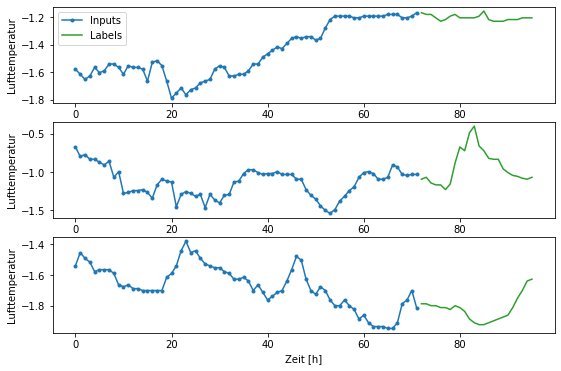

In [42]:
w1.plot()

# Define model & metrics

In [43]:
tf.keras.backend.clear_session()

# Input for embeddings
embedding_inputs = tf.keras.Input(shape =(INPUT_WIDTH,))
embedding_layer = tf.keras.layers.Embedding(input_dim=N_EMBEDDING_DIMS + 1, 
                                            output_dim=2, input_length=INPUT_WIDTH)(embedding_inputs)

# Input for features
feature_inputs = tf.keras.layers.Input(shape=(INPUT_WIDTH, n_features))

# Concat embeddings &  features
concat_layer = tf.keras.layers.Concatenate()([embedding_layer, feature_inputs])

lstm_layer = tf.keras.layers.LSTM(13, return_sequences=True)(concat_layer)
lstm_layer = tf.keras.layers.LSTM(13, return_sequences=True)(lstm_layer)
lstm_layer = tf.keras.layers.LSTM(13, return_sequences=True)(lstm_layer)[:,-LABEL_WIDTH:,:]

# Apply a dense output layer on every timestep of the LSTM
output = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(units=1, activation='linear')
)(lstm_layer)

# Build the model
model = tf.keras.Model(inputs=[feature_inputs, embedding_inputs], outputs=output)

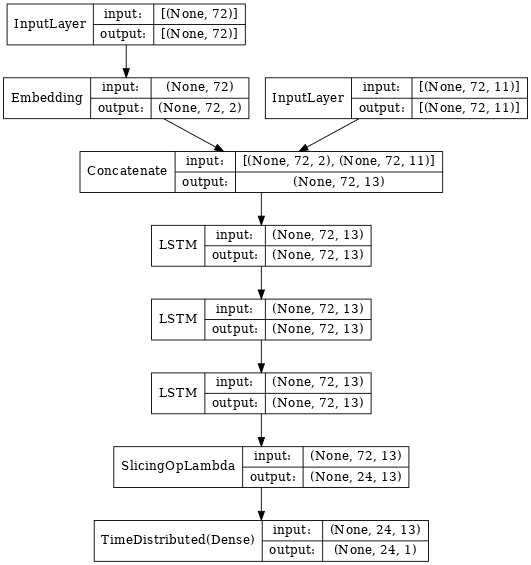

In [18]:
tf.keras.utils.plot_model(
    model, to_file=vis_dir/'forecast_model_architecture.png', show_shapes=True, 
    show_layer_names=False, rankdir='TB', expand_nested=False, dpi=64
)

# Train model

In [45]:
# Train configs
MAX_EPOCHS = 30

In [46]:
METRICS = [
      tf.keras.metrics.MeanAbsoluteError(name='MAE')
]

In [47]:
def compile_and_fit(model,
                    train_dataset,
                    validation_dataset,
                    save_to=None, 
                    patience=3, 
                    lr=1e-4, 
                    max_epochs=MAX_EPOCHS,
                    metrics=METRICS,
                    batch_size=BATCH_SIZE,
                    verbose=True):

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights=True)
    
    save_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=save_to,
                                                         save_weights_only=False,
                                                         monitor='val_loss',
                                                         mode='min',
                                                         save_best_only=True,
                                                         save_freq='epoch')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(lr=lr),
                metrics=metrics)

    history = model.fit(train_dataset, epochs=max_epochs,
                      validation_data=validation_dataset,
                      callbacks=[early_stopping],  # save_checkpoint not used atm
                      batch_size=batch_size,
                      verbose=verbose)
                      
    return history

In [48]:
model_name = 'lstm_basic_' + \
        datetime.datetime.today().strftime('%y%m%d')

history = compile_and_fit(model, w1.train, w1.val, save_to=str(saved_model_dir/model_name))

Epoch 1/30
3282/3282 [==============================] - 185s 55ms/step - loss: 0.5134 - MAE: 0.5454 - val_loss: 0.2019 - val_MAE: 0.3490
Epoch 2/30
3282/3282 [==============================] - 232s 71ms/step - loss: 0.1876 - MAE: 0.3358 - val_loss: 0.1734 - val_MAE: 0.3241
Epoch 3/30
3282/3282 [==============================] - 254s 77ms/step - loss: 0.1670 - MAE: 0.3168 - val_loss: 0.1652 - val_MAE: 0.3177
Epoch 4/30
3282/3282 [==============================] - 243s 74ms/step - loss: 0.1564 - MAE: 0.3063 - val_loss: 0.1569 - val_MAE: 0.3098
Epoch 5/30
3282/3282 [==============================] - 301s 92ms/step - loss: 0.1473 - MAE: 0.2966 - val_loss: 0.1491 - val_MAE: 0.3004
Epoch 6/30
3282/3282 [==============================] - 217s 66ms/step - loss: 0.1409 - MAE: 0.2891 - val_loss: 0.1468 - val_MAE: 0.2984
Epoch 7/30
3282/3282 [==============================] - 295s 90ms/step - loss: 0.1363 - MAE: 0.2837 - val_loss: 0.1459 - val_MAE: 0.2977
Epoch 8/30
3282/3282 [===================

In [49]:
model.save(str(saved_model_dir/model_name))

[2021-08-29 12:01:46 | save] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn while saving (showing 5 of 15). These functions will not be directly callable after loading.
[2021-08-29 12:01:46 | save] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /home/heckert/projects/sbg-weather/data/saved_models/lstm_basic_210829/assets


[2021-08-29 12:01:48 | builder_impl] Assets written to: /home/heckert/projects/sbg-weather/data/saved_models/lstm_basic_210829/assets


Text(0, 0.5, 'val_loss')

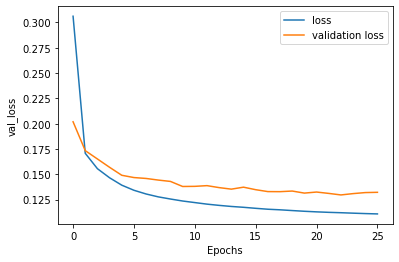

In [50]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(labels = ["loss", "validation loss"])
plt.xlabel("Epochs")
plt.ylabel("val_loss")

In [51]:
model.evaluate(w1.test)

546/546 [==============================] - 20s 35ms/step - loss: 0.1397 - MAE: 0.2813


[0.13966414332389832, 0.2813224494457245]

In [13]:
model = tf.keras.models.load_model(saved_model_dir/'lstm_basic_210829')

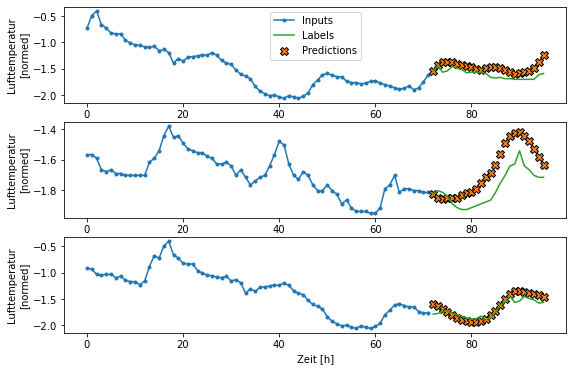

In [14]:
w1.plot(model=model)